In [1]:
import os
import numpy as np
import pandas as pd
import json
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import MultiComparison

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from anatomy.anatomy_api import AnatomyApi

In [2]:
basepath = r'../../../'
datpath = r'../data_files'
fig5_path = os.path.join(basepath, '_final_figures', 'Figure_5')

c_by_source = pd.read_csv(os.path.join(datpath, 'good_wt_correlations.csv'))
print(len(c_by_source))
alldat = pd.read_csv(os.path.join(datpath, 'good_td_wt_correlations.csv'))
print(len(alldat))
td_dat = pd.read_csv(os.path.join(datpath, 'good_td_td_correlations.csv'))
print(len(td_dat))
dataset = pd.read_csv(os.path.join(datpath, 'target_defined_dataset.csv'))
dataset = dataset[dataset['include'] == 'yes']
print(len(dataset))

627
586
241
121


In [7]:
mcc = MouseConnectivityCache(manifest_file = 'connectivity/mouse_connectivity_manifest.json')
aapi = AnatomyApi()
ss = aapi.get_summary_structure_data('id')
new_expts = [868641659]
new_expts = [expt for expt in new_expts if expt in dataset['image_series_id'].values]
online_expts = [expt for expt in dataset['image_series_id'].unique() if expt not in new_expts]
td_exps = mcc.get_structure_unionizes(experiment_ids = online_expts,
                                    is_injection = False, structure_ids = ss, 
                                     hemisphere_ids = [3])
td_exps = td_exps[['hemisphere_id', 'experiment_id', 'is_injection',
       'normalized_projection_volume', 'projection_volume', 'structure_id']]
print(len(td_exps))

37920


In [9]:
for isid in new_expts:
    unionize_path = os.path.join(datpath, 'alternative_unionizes',
                                         'experiment_{0}'.format(str(isid)), 
                                         'output.json') #new data not online yet
    with open(unionize_path, 'r') as jsonfile:
        unionize_dat = json.load(jsonfile)
    unionize_dat = pd.DataFrame(unionize_dat)
    unionize_dat = unionize_dat[unionize_dat['threshold'] == 0]
    unionize_dat.drop_duplicates(inplace = True)
    unionize_dat.rename(columns = {'projection_volume_above_threshold': 'projection_volume',
                               'normalized_projection_volume_above_threshold': 
                                   'normalized_projection_volume',
                                   'image_series_id': 'experiment_id'}, 
        inplace = True)
    unionize = unionize_dat[(unionize_dat['is_injection'] == False) &
                          (unionize_dat['structure_id'].isin(ss)) &
                          (unionize_dat['hemisphere_id'] == 3)]
    unionize = unionize[['hemisphere_id', 'experiment_id', 'is_injection',
       'normalized_projection_volume', 'projection_volume', 'structure_id']]
    td_exps = td_exps.append(unionize)
print(len(td_exps))

38163


In [10]:
td_count = []
wt_count = []
td_sum = []
wt_sum = []
for isid in alldat['image_series_id'].unique():
    td = td_exps[(td_exps['experiment_id'] == isid) &
                     (td_exps['hemisphere_id'] == 3)][
        'normalized_projection_volume']
    td_count.append(len(td[np.log10(td.values) > -1.5]))
    td_sum.append(td[np.log10(td.values) > -1.5].sum())
    wts = pd.DataFrame()
    match_set = alldat[alldat['image_series_id'] == isid]
    match_unionizes = mcc.get_structure_unionizes(
        experiment_ids = match_set['match_id'].unique(),
        is_injection = False, structure_ids = ss, 
        hemisphere_ids = [3])
    if len(match_set) > 0:
        for match_id in match_set['match_id'].unique():
            wt = match_unionizes[(match_unionizes['experiment_id'] == match_id)][
            'normalized_projection_volume']
            wts = pd.concat([wts, wt], axis = 1)
    wt_count.append(wts[np.log10(wts.values) > -1.5].count().mean())
    wt_sum.append(wts[np.log10(wts.values) > -1.5].sum().mean())

/opt/anaconda3/envs/DMN/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/opt/anaconda3/envs/DMN/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/envs/DMN/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/envs/DMN/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10


In [11]:
df = pd.DataFrame({'image_series_id': alldat['image_series_id'].unique(),
                  'td_num_targets': td_count,
                  'wt_num_targets': wt_count,
                  'td_sum': td_sum,
                  'wt_sum': wt_sum})

In [14]:
meandat = pd.read_csv(os.path.join(datpath, 'td_mean_corr_dat.csv'))

In [15]:
df = df.merge(meandat, on = 'image_series_id', how = 'left')

In [16]:
df['wt_num_targets'].max()

123.0

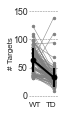

In [17]:
fig, ax = plt.subplots(figsize = (1, 1.7))
ax.errorbar([0, 1], [df['wt_num_targets'].mean(), 
                     df['td_num_targets'].mean()],
               yerr = [df['wt_num_targets'].std(), 
                    df['td_num_targets'].std()],
              c = 'k', marker = 'o', linewidth = 2, zorder = 3);
for index, row in df.iterrows():
    ax.plot([0, 1], [row['wt_num_targets'], row['td_num_targets']], 
            marker = '.', color = 'gray', linewidth = 0.5, zorder = -1)
ax.tick_params(pad = -3)
ax.set_xlim([-0.2,1.2])
ax.set_xticks([0.1,0.9])
ax.set_xticklabels(['WT', 'TD'], fontsize = 8)
ax.yaxis.labelpad = -1
ax.set_ylabel('# Targets', fontsize = 8)
ax.axhline(y = 0, xmin=0, xmax=1.2, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5)
ax.axhline(y = 50, xmin=0, xmax=1.2, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5)
ax.axhline(y = 100, xmin=0, xmax=1.2, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5)
ax.axhline(y = 150, xmin=0, xmax=1.2, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5)
plt.tight_layout()
sns.despine(left = True, bottom = True)
#plt.savefig(os.path.join(fig5_path, 'num_targets wt-td ipsi_and_contra.pdf'), format = 'pdf', 
#            resolution = 300, transparent = True)

In [18]:
stats.ttest_ind(df['wt_num_targets'], df['td_num_targets'])

Ttest_indResult(statistic=11.569961008480199, pvalue=1.8871758808063676e-24)

In [19]:
df.describe()

,image_series_id,td_num_targets,wt_num_targets,td_sum,wt_sum,spearman_correlation,exp_predicted,low_pred_band,CAV_percent_DMN,number of comparisons,injection_size,fraction_low_corr,mean_overlap
count,1.100000e+02,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,105.000000,110.000000,110.000000,110.000000,110.000000
mean,5.587594e+08,32.863636,63.085115,23.143103,28.388921,0.771926,0.785095,0.670158,59.748871,5.327273,0.025866,0.130963,0.348768
std,5.624133e+07,17.097388,21.405512,23.116766,10.707105,0.105292,0.047701,0.046342,44.035296,5.200757,0.037015,0.281210,0.200658
min,4.756176e+08,9.000000,31.083333,4.630211,7.433941,0.235626,0.719958,0.610342,0.000000,1.000000,0.000518,0.000000,0.053977
25%,5.214307e+08,24.250000,44.125000,10.961129,18.463662,0.736018,0.743370,0.630324,2.586009,2.000000,0.004338,0.000000,0.196140
50%,5.615094e+08,30.000000,63.000000,17.283117,29.530130,0.784050,0.774211,0.660134,88.132916,3.500000,0.013546,0.000000,0.321734
75%,5.922405e+08,36.000000,77.857143,27.478421,37.254936,0.842531,0.823531,0.706872,99.659112,7.000000,0.031588,0.000000,0.477950
max,8.686417e+08,138.000000,123.000000,175.901804,52.418624,0.931809,0.890684,0.781197,100.000000,23.000000,0.242198,1.000000,1.130372


In [20]:
df[df['wt_num_targets'] < df['td_num_targets']][['image_series_id', 'source', 
                                                           'target_by_polygon',
                                                          'td_num_targets',
                                                          'wt_num_targets']]

,image_series_id,source,target_by_polygon,td_num_targets,wt_num_targets
50,518012479,VISl,VISp,110,49.500000
76,539511058,VISp,VISpor,38,35.833333
91,531443949,RSPv,VISpor,39,33.000000
105,484612961,ECT,PL,94,92.000000
109,868641659,RSPv,VISp,138,63.000000


In [21]:
replicates = td_dat.loc[np.where(td_dat['td_target'].values == td_dat['match_target'].values)]

In [22]:
c_by_source['pair_type'] = 'WT-WT'
alldat['pair_type'] = 'WT-TD'

In [23]:
pltdat = pd.concat([c_by_source[['pair_type', 'spearman_correlation', 'source']],
                    alldat[['pair_type', 'spearman_correlation', 'source']]])

In [24]:
pltdat.pair_type.unique()

array(['WT-WT', 'WT-TD'], dtype=object)

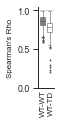

In [25]:
fig, ax = plt.subplots(figsize = (0.3, 1.5))
sns.boxplot('pair_type', 'spearman_correlation', data = pltdat,
           ax = ax, palette = ['gray', 'w'], linewidth = 0.5, fliersize = 1)
sns.despine()
plt.xticks([0,1.2], rotation=90)
ax.set_xlim([-0.7, 1.7])
ax.set_ylim([0, 1.05])
ax.tick_params(bottom = False, left = True)
ax.tick_params('x', pad=-3)
ax.set_ylabel("Spearman's Rho", fontsize = 8)
ax.set_xlabel("");
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 8)
ax.axhline(y=1, xmin=-0.7, xmax=1.7, color = 'grey', linestyle = 'dashed', 
           linewidth = 0.5, zorder = -1)
#plt.savefig(os.path.join(fig5_path, 'correlation_by_pair_type.pdf'),
#                        bbox_inches='tight', pad_inches=0.3, transparent = True, dpi = 300)

In [26]:
stats.ttest_ind(pltdat[pltdat['pair_type'] == 'WT-WT']['spearman_correlation'],
                pltdat[pltdat['pair_type'] == 'WT-TD']['spearman_correlation'])

Ttest_indResult(statistic=17.099016176698232, pvalue=6.976661940679885e-59)

In [27]:
pltdat.groupby('pair_type').describe()

spearman_correlation                                          \
                         count      mean       std       min       25%   
pair_type                                                                
WT-TD                    586.0  0.777056  0.095607  0.208107  0.725525   
WT-WT                    627.0  0.859518  0.071317  0.596485  0.813910   

                                         
                50%       75%       max  
pair_type                                
WT-TD      0.783067  0.840576  0.995513  
WT-WT      0.867519  0.914891  0.997767

In [28]:
c_by_source['expt_type'] = 'WT-WT'
alldat['expt_type'] = 'WT-TD'
td_dat['expt_type'] = 'TD-TD'

In [29]:
c_by_source['low_corr'] = False #don't use these because model was constructed
                                # with this data
alldat['low_corr'] = alldat['spearman_correlation'] < alldat['low_pred_band']
td_dat['low_corr'] = td_dat['spearman_correlation'] < td_dat['low_pred_band']

In [30]:
pltdat = pd.concat([c_by_source[['source', 'spearman_correlation', 'expt_type', 'low_corr']],
                    alldat[['source', 'spearman_correlation', 'expt_type', 'low_corr']],
                    td_dat[['source', 'spearman_correlation', 'expt_type', 'low_corr']]])

In [31]:
len(pltdat)

1454

In [32]:
pltdat = pltdat[pltdat['source'].isin(alldat['source'].unique())]
#pltdat = pltdat[pltdat['source'].isin(c_by_source['source'].unique())]
print(len(pltdat))

1407


In [33]:
plot_order = ['ACAd', 'ACAv', 'PL', 'ILA', 'ORBl', 'ORBm', 'ORBvl', 'VISa', 'VISam', 
              'RSPagl', 'RSPd', 'RSPv', 'MOs', 'SSp-tr', 'SSp-ll',
              'VISpm', 'ECT', 'VISl', 'VISp', 'VISli', 'VISpor', 'VISrl']
print([source for source in plot_order if source not in pltdat['source'].unique()])
print([source for source in pltdat['source'].unique() if source not in plot_order])

[]
[]


In [34]:
pltdat['expt_type'].unique()

array(['WT-WT', 'WT-TD', 'TD-TD'], dtype=object)

/opt/anaconda3/envs/DMN/lib/python3.7/site-packages/seaborn/categorical.py:1187: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


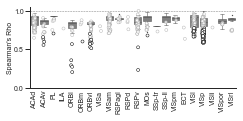

In [35]:
fig, ax = plt.subplots(figsize = (3.7, 1.5))
sns.boxplot('source', 'spearman_correlation', data = pltdat,
            order = plot_order, hue = 'expt_type',
           ax = ax, palette = ['gray', 'w'], 
            hue_order = ['WT-WT'], linewidth = 0.5, fliersize = 0.5)
sns.stripplot('source', 'spearman_correlation', 
              data = pltdat[~pltdat['low_corr']],
            order = plot_order, hue = 'expt_type',
              s=3,
           ax = ax, palette = ['w'], 
            hue_order = ['WT-TD'], linewidth = 0.5, dodge = True,
             alpha = 0.7)
sns.stripplot('source', 'spearman_correlation', 
              data = pltdat[pltdat['low_corr']],
            order = plot_order, hue = 'expt_type',
              s=3,
           ax = ax, palette = ['w'], 
            hue_order = ['WT-TD'], linewidth = 0.5, edgecolor='k', dodge = True)
sns.despine()
ax.tick_params(bottom = True, left = True)
ax.set_ylabel("Spearman's Rho", fontsize = 7, labelpad=1)
ax.set_xlabel("");
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 7, rotation=90)
ax.set_ylim([0,1.05])
ax.tick_params(top = False, right = False, left = True, bottom = False, pad = 1)
ax.tick_params(axis = 'x', pad=-3)
ax.set_xticks(np.linspace(ax.get_xbound()[0]+0.5, 
                          ax.get_xbound()[1]-0.5, len(plot_order)))
plt.xticks(rotation = 90, fontsize = 7)
plt.yticks([0, 0.5, 1], fontsize = 7)
ax.axhline(y=1, xmin=0, xmax=1, color = 'grey', linestyle = 'dashed', 
           linewidth = 0.5, zorder = -1)
ax.legend_.remove()
#plt.savefig(os.path.join(fig5_path, 'correlation_by_source_type.pdf'),
#                        bbox_inches='tight', pad_inches=0.3, transparent = True, dpi = 300)

In [36]:
len(alldat[alldat['low_corr']])/len(alldat)

0.13651877133105803

In [37]:
print(len(alldat[alldat['spearman_correlation'] < alldat['low_pred_band']]))
print(len(alldat[alldat['spearman_correlation'] > alldat['high_pred_band']]))
print(len(alldat))

80
43
586


In [38]:
(80+43)/586

0.2098976109215017

In [39]:
len(alldat[alldat['source'] == 'ACAv'])

12

In [40]:
len(alldat[alldat['source'] == 'ACAd'])

50

In [41]:
len(alldat[alldat['source'] == 'ILA'])

1

In [42]:
[source for source in alldat[
    (alldat['low_corr'])]['source'].unique() if source not in c_by_source['source'].unique()]

['ORBm']

In [43]:
sourcedat = meandat.groupby('source').mean().reset_index()

[]


/opt/anaconda3/envs/DMN/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


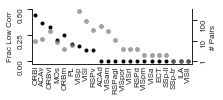

In [44]:
order = ['ORBl', 'ACAv', 'ORBvl', 'MOs', 'ORBm', 'PL', 'VISp', 'VISl', 'RSPv', 
        'ACAd', 'VISam', 'RSPagl', 'VISpor', 'VISrl', 'RSPd', 'VISpm', 'VISa',  
        'ECT', 'SSp-ll', 'SSp-tr', 'ILA', 'VISli']
print([source for source in sourcedat['source'].unique() if source not in order])
numpairs = pd.DataFrame(alldat.groupby('source').count()['distance']).reset_index()
numpairs['log_scale'] = [np.log10(count) for count in numpairs['distance'].values]
fig, ax = plt.subplots(figsize = (3.2, 1.5))
sns.stripplot('source', 'fraction_low_corr', 
              data = sourcedat, 
            order = order, color = 'k', zorder = 1, 
             dodge = False, jitter = False, s=4)
plt.xticks(rotation = 90, fontsize = 8);
plt.yticks([0, 0.25, 0.5], rotation = 90, fontsize = 8);
ax2 = ax.twinx()
sns.stripplot('source', 'log_scale', 
              data = numpairs, 
            order = order, color = 'gray', ax = ax2, edgecolors = 'k', linewidth=0.5,
             dodge = False, jitter = False, alpha = 0.7, zorder = 0, s=4)
plt.yticks(rotation = 90, fontsize = 8);
ax.tick_params(top=False, right=False, left=True)
ax.tick_params('x', pad = -3)
sns.despine(right = False)
ax.set_ylabel('Frac Low Corr', fontsize = 8)
ax.set_xlabel(None)
ax2.set_ylabel('# Pairs', fontsize = 8) 
ax2.set_yticklabels([0, 1, 10, 100])
plt.tight_layout()
#plt.savefig(os.path.join(fig5_path, 
#                         'proj_diversity_by_source.pdf'), 
#            bbox_inches='tight', format='pdf', transparent = True, dpi=300)

In [45]:
stats.pearsonr(sourcedat['fraction_low_corr'].values, 
                sourcedat['number of comparisons'].values)

(0.07964459321331338, 0.7245976462313162)

In [46]:
def assign_module(df):
    df.loc[df['source'].isin(['ACAd', 'ACAv', 'ORBl','ORBm', 'ORBvl', 
                                                    'ILA', 'PL', 'FRP']), 'module'] = 'Prefrontal'
    df.loc[df['source'].isin(['VISam', 'RSPagl', 'RSPv', 'VISpm',
                                                    'VISa', 'RSPd']), 'module'] = 'Medial'
    df.loc[df['source'].isin(['SSp-tr', 'SSp-ll', 'SSp-bfd', 'SSp-un',
                                                    'SSp-ul', 'MOs', 'MOp', 'SSs', 'SSp-n',
                                                    'SSp-m']), 'module'] = 'Somatomotor'
    df.loc[df['source'].isin(['VISal', 'VISl', 'VISli', 'VISp', 'VISpl',
                                                    'VISpor', 'VISrl']), 'module'] = 'Visual'
    df.loc[df['source'].isin(['AUDpo', 'AUDd', 'AUDp', 'AUDv']), 
                    'module'] = 'Auditory'
    df.loc[df['source'].isin(['TEa', 'PERI', 'ECT', 'GU', 'AId', 'AIv',
                                                    'AIp', 'VISC']), 'module'] = 'Lateral'
    print(len(df[df['module'].isnull()]))
    return df

0


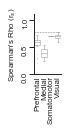

In [47]:
alldat = assign_module(alldat)
mod_order = ['Prefrontal', 'Medial', 'Somatomotor', 'Visual']
fig, ax = plt.subplots(1, figsize = (0.5, 1.1))
sns.boxplot('module', 'spearman_correlation', 
            data = alldat[alldat['spearman_correlation'] < alldat['low_pred_band']], 
            order = mod_order, ax = ax,
            fliersize = 0.1, color = 'w', linewidth = 0.5)
ax.tick_params(top = False, right = False)
ax.set_ylim([0,1.1])
plt.yticks([0, 0.5, 1], rotation = 90, fontsize = 8)
plt.xticks(rotation = 90, fontsize = 8)
ax.set_xlabel("", fontsize = 8)
ax.set_ylabel("Spearman's Rho (r$_s$)", fontsize = 8)
ax.tick_params(top = False, right = False, left = True, bottom = False, pad = 1)
ax.tick_params(axis = 'x', pad=-3)
sns.despine()
ax.axhline(y = 0.775, xmin=0, xmax=1.2, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5, zorder = -1)
#plt.savefig(os.path.join(fig5_path, 'TD-WT_low_corr_by_module_boxplot.pdf'), 
#            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

In [48]:
formula = 'spearman_correlation~C(module)' 
model = ols(formula, alldat[alldat['spearman_correlation'] < alldat['low_pred_band']]).fit()
aov_table = anova_lm(model, typ=2) #http://www.utstat.utoronto.ca/reid/sta442f/2009/typeSS.pdf
aov_table.round(4)

,sum_sq,df,F,PR(>F)
C(module),0.4744,3.0,20.9025,0.0
Residual,0.5750,76.0,NaN,NaN


In [49]:
alldat['module'].unique()

array(['Visual', 'Prefrontal', 'Somatomotor', 'Medial', 'Lateral'],
      dtype=object)

In [50]:
f_value, p_value = stats.f_oneway(
    alldat[alldat['module'] == 'Prefrontal']['spearman_correlation'], 
    alldat[alldat['module'] == 'Medial']['spearman_correlation'],
    alldat[alldat['module'] == 'Somatomotor']['spearman_correlation'],
    alldat[alldat['module'] == 'Visual']['spearman_correlation']
)
print(f_value, p_value)

11.845313772987915 1.5390558325931493e-07


In [51]:
module_pairs = []
modules = ['Visual', 'Prefrontal', 'Medial', 'Somatomotor']
pvals = []

for mod1 in range(3):
    for mod2  in range(mod1+1,4):
        module_pairs.append((modules[mod1], modules[mod2]))
        
# Conduct t-test on each pair
for module1, module2 in module_pairs: 
    print(module1, module2)
    print(stats.ttest_ind(alldat[alldat['module'] == module1]['spearman_correlation'], 
                          alldat[alldat['module'] == module2]['spearman_correlation'])) 
    pvals.append(stats.ttest_ind(alldat[alldat['module'] == module1]['spearman_correlation'], 
                          alldat[alldat['module'] == module2]['spearman_correlation'])[1])

Visual Prefrontal
Ttest_indResult(statistic=2.6838917217131995, pvalue=0.0075254176909822215)
Visual Medial
Ttest_indResult(statistic=-5.324682693737474, pvalue=1.5877428204678714e-07)
Visual Somatomotor
Ttest_indResult(statistic=-0.16806183454304804, pvalue=0.8666226538161222)
Prefrontal Medial
Ttest_indResult(statistic=-4.58336104403097, pvalue=8.181872865391765e-06)
Prefrontal Somatomotor
Ttest_indResult(statistic=-0.7899516372046798, pvalue=0.43108873630825506)
Medial Somatomotor
Ttest_indResult(statistic=1.6521291375475375, pvalue=0.1018449293862432)


In [52]:
fdrcorr = sm.stats.fdrcorrection(pvals, alpha=0.05, method='indep')
print(fdrcorr)

(array([ True,  True, False,  True, False, False]), array([1.50508354e-02, 9.52645692e-07, 8.66622654e-01, 2.45456186e-05,
       5.17306484e-01, 1.52767394e-01]))


In [53]:
alldat['prediction_error'] = alldat['spearman_correlation'] - alldat['exp_predicted']
pltdat = alldat.groupby('source').mean().reset_index()
pltdat.head(1)

,source,distance,exclusion_zone_overlap,fraction of match covered by td exclusion zone,fraction of match covered by td injection,image_series_id,injection_overlap,match_id,pearson_correlation,spearman_correlation,...,same_secondary,injection_size_ratio,dice,CAV_percent_DMN,exp_predicted,low_pred_band,high_pred_band,sig,low_corr,prediction_error
0,ACAd,252.919539,0.365772,0.771205,0.319479,5.700463e+08,0.629327,3.763765e+08,0.883542,0.815654,...,0.72,14.981729,0.511208,87.468797,0.805474,0.69935,0.911598,0.0,0.0,0.01018


In [54]:
alldat['spearman_correlation'].mean()

0.7770561269829352

In [56]:
print([source for source in alldat['source'].unique() if len(alldat[
    (alldat['source'] == source) & (alldat['spearman_correlation'] < alldat['low_pred_band'])
]) > 1])

['VISp', 'VISl', 'ORBvl', 'ACAv', 'ORBl', 'RSPv']


[]


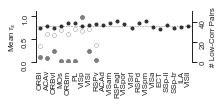

In [64]:
lc_dat = alldat[alldat['spearman_correlation'] < alldat[
    'low_pred_band']].groupby('source').mean().reset_index()
hc_dat = alldat[alldat['spearman_correlation'] > alldat[
    'low_pred_band']].groupby('source').mean().reset_index()
countdat = alldat[alldat['spearman_correlation'] < alldat[
    'low_pred_band']].groupby('source').count().reset_index()
countdat['log_scale'] = [np.log10(count) for count in countdat['distance'].values]
order = ['ORBl', 'ACAv', 'ORBvl', 'MOs', 'ORBm', 'PL', 'VISp', 'VISl', 'RSPv', 
        'ACAd', 'VISam', 'RSPagl', 'VISpor', 'VISrl', 'RSPd', 'VISpm', 'VISa',  
        'ECT', 'SSp-ll', 'SSp-tr', 'ILA', 'VISli']
print([source for source in pltdat['source'].unique() if source not in order])
fig, ax = plt.subplots(figsize = (3.2, 1.5))
sns.stripplot('source', 'spearman_correlation', 
              data = hc_dat[hc_dat['source'].isin(order)], 
            order = order, color = 'k', ax = ax,
             dodge = False, jitter = False, s=4, alpha = 0.8
             )
sns.stripplot('source', 'spearman_correlation', 
              data = lc_dat[lc_dat['source'].isin(order)], 
            order = order, color = 'w', ax = ax, linewidth=0.5,
             dodge = False, jitter = False, s=4)
plt.xticks(rotation = 90, fontsize = 8);
plt.yticks(rotation = 90, fontsize = 8);
ax2 = ax.twinx()
sns.stripplot('source', 'spearman_correlation', 
              data = countdat[countdat['source'].isin(order)], 
            order = order, color = 'gray', ax = ax2, linewidth=0.5,
             dodge = False, jitter = False, s=4)
plt.yticks(rotation = 90, fontsize = 8);
ax.set_ylim([0,1.1])
ax.tick_params(top=False, right=False, bottom = False, left=True)
ax.set_yticks([0, 0.5, 1])
ax.set_ylabel("Mean r$_s$", fontsize = 8)
ax.set_xlabel(None)
sns.despine(right = False, bottom=True, left=False)
ax2.tick_params(right=True)
ax2.set_ylim([0,50])
ax2.set_yticks([0, 20, 40])
ax2.set_ylabel("# Low-Corr Pairs", fontsize = 8)
ax.axhline(y = 0.775, xmin=0, xmax=1.2, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5)
plt.tight_layout()
#plt.savefig(os.path.join(fig5_path, 
#                         'corr_by_source.pdf'), 
#            bbox_inches='tight', format='pdf', transparent = True, dpi=300)